In [1]:
from numpy import tan, pi, sqrt
from scipy.optimize import minimize
from scipy.constants import e,h,hbar,k,G,epsilon_0
phi_0 = hbar/2./e
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qutip import *
from scipy import signal
import matplotlib as mpl
import time
mpl.rcParams['axes.linewidth'] = 2
import plots

In [2]:
def fluxmod(t, arg):
    return amp*np.cos(2*np.pi*omega*t)

In [3]:
# qubit (a)
amp=1*1e8
fq = 7e9-amp
Aq = 300e6
gamma = 1e1
gamma1= 0

# cavity (b)   
fc = 7.1e9
kappa = 1e1
cavity_spec = 3

g=2*np.pi*1e+6
omega=fc-fq
# omega=0
psi0 = tensor(basis(2,0),basis(cavity_spec,0))      # initial state
tlist = np.linspace(0.0*1e-9, 1*1e-6, 1000)

ex_ops = ['sz', 'num_b']

In [4]:
def qubit_integrate(fq, fc, Aq, g, tlist, ex_ops):
    
    b = tensor(qeye(2), destroy(cavity_spec))
    sx = tensor(sigmax(),qeye(cavity_spec))
    sz = tensor(sigmaz(),qeye(cavity_spec))
    sm = tensor(destroy(2),qeye(cavity_spec))
    num_b = b.dag()*b
   

    
    H0 = 2*np.pi*(fq)*0.5*sz+2*np.pi*(fc)*num_b + g*(b+b.dag())*sx
    H1 = 2*np.pi*0.5*sz
    
    H = [H0, [H1, fluxmod]]
    
    # collapse operators
    c_op_list = []
    n_th = 0.0 # zero temperature

    # relaxation
    rate = gamma * (1 + n_th)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm)
    # excitation
    rate = gamma * n_th
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm.dag())
    # dephasing 
    rate = gamma1
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sz)
    # cavity relaxation
    rate = kappa
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b)
    
    e_ops = []
    if 'sx' in ex_ops:
        e_ops.append(sx)
    if 'sy' in ex_ops:
        e_ops.append(sy)
    if 'sz' in ex_ops:
        e_ops.append(sz)
    if 'sm' in ex_ops:
        e_ops.append(sm)
    if 'num_b' in ex_ops:
        e_ops.append(num_b)
    output = mesolve(H, psi0, tlist, c_op_list, e_ops)
    return output  

In [5]:
output = qubit_integrate(fq,fc,Aq,g,tlist, ex_ops)

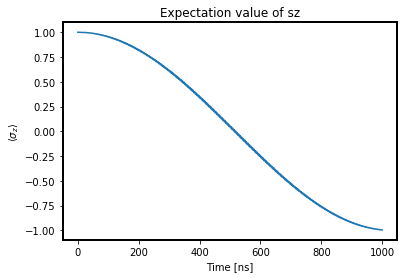

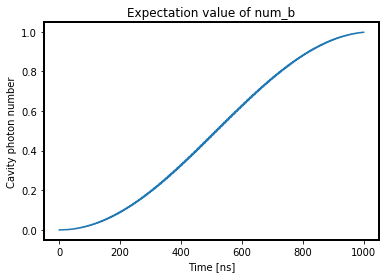

In [6]:
plots.expect(output.expect, tlist, 'sz', ex_ops)
plots.expect(output.expect, tlist, 'num_b', ex_ops)

In [7]:
ex_ops = []
output = qubit_integrate(fq,fc,Aq,g,tlist, ex_ops)

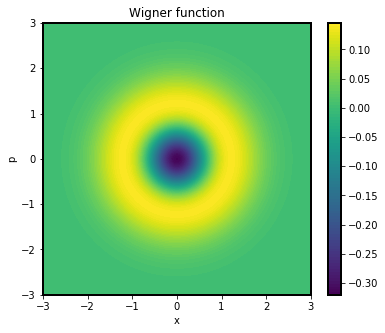

Density matrix:
[[ 0.+0.j  0.+0.j  0.-0.j]
 [ 0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j]]


In [12]:
ind = 500
obj = 1
cont0 = plots.wigner(output.states, obj=obj, ind=ind)
dm = plots.dmat(output.states, obj=obj, ind=ind, roff=2)
plots.dmatf(output.states, tlist, obj=1, elems=[[0,0], [1,1], [2,2]], obj_descr='cavity')